In [29]:
import numpy as np
import pandas as pd	
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score
import datetime
import keras_tuner as kt


In [30]:

'''fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()'''
fashion_mnist = tf.keras.datasets.mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

In [31]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
    model.add(tf.keras.layers.Dense(units=hp.Int('units_1', min_value=320, max_value=512, step=32), activation='relu'))
    model.add(tf.keras.layers.Dense(units=hp.Int('units_2', min_value=32, max_value=320, step=32), activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    
    model.compile(optimizer=tf.keras.optimizers.SGD(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [32]:
from kerastuner.tuners import RandomSearch

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(301, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(
    optimizer = optimizer,
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"])


'''tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=15,  # Number of hyperparameter combinations to try
    executions_per_trial=3,  # Number of times to evaluate each combination
)

tuner.search(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

model = tuner.hypermodel.build(best_hps)'''

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [33]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_9 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8523 - loss: 0.4636 - val_accuracy: 0.9516 - val_loss: 0.1519
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9357 - loss: 0.2036 - val_accuracy: 0.9672 - val_loss: 0.1172
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9476 - loss: 0.1669 - val_accuracy: 0.9692 - val_loss: 0.1080
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9525 - loss: 0.1501 - val_accuracy: 0.9688 - val_loss: 0.1071
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9578 - loss: 0.1345 - val_accuracy: 0.9724 - val_loss: 0.0974
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9601 - loss: 0.1247 - val_accuracy: 0.9712 - val_loss: 0.0974
Epoch 7/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9651 - loss: 0.1122 - val_accuracy: 0.9726 - val_loss: 0.1041
Epoch 8/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9643 - loss: 0.1069 - 

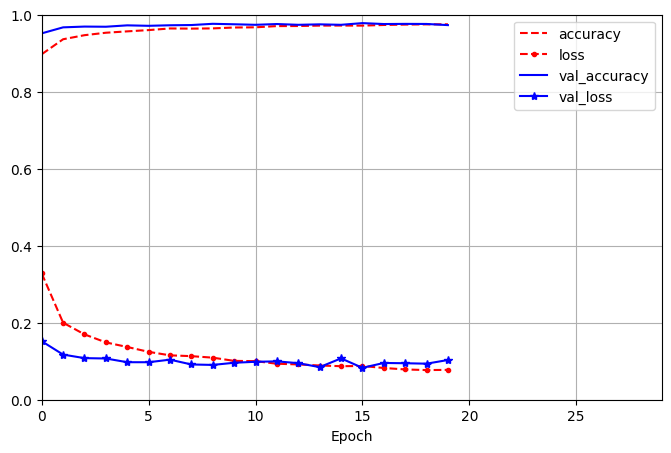

0.9728

In [34]:
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=False):
        return super().call(inputs, training=True)


model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    MCDropout(rate=0.2),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal",
    use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    MCDropout(rate=0.2),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal",
    use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    MCDropout(rate=0.2),
    tf.keras.layers.Dense(15, activation="softmax")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)
model.compile(
    optimizer = optimizer,
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"])


Epoch 1/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9765 - loss: 0.0716 - val_accuracy: 0.9796 - val_loss: 0.0852
Epoch 2/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9783 - loss: 0.0674 - val_accuracy: 0.9748 - val_loss: 0.0987
Epoch 3/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9760 - loss: 0.0759 - val_accuracy: 0.9778 - val_loss: 0.0891
Epoch 4/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9765 - loss: 0.0723 - val_accuracy: 0.9786 - val_loss: 0.0823
Epoch 5/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9754 - loss: 0.0712 - val_accuracy: 0.9804 - val_loss: 0.0773
Epoch 6/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9781 - loss: 0.0671 - val_accuracy: 0.9806 - val_loss: 0.0871
Epoch 7/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9775 - loss: 0.0685 - val_accuracy: 0.9794 - val_loss: 0.0934
Epoch 8/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9771 - loss: 0.0681 - 

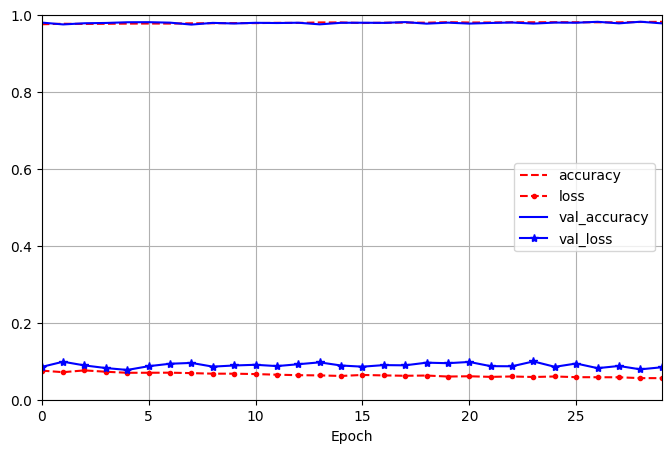

0.9764

In [35]:

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid), callbacks=[tensorboard_callback])

y_pred = model.predict(X_test)
accuracy_score(y_test, np.argmax(y_pred, axis=-1))
pd.DataFrame(history.history).plot(
figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
style=["r--", "r--.", "b-", "b-*"])
plt.show()
accuracy_score(y_test, np.argmax(y_pred, axis=-1))

9851